## The hypothesis

<span style="color:green;font-weight:bold">We generated feature maps for many convolutional layers and found that many of those maps contained patterns that resemble (vaguely) some real-world entities.
Since the feature maps are essentially what the network looks for when looking at a new image, we formulate the following hypothesis</span>

<span style="color:green;font-weight:bold">1. We identify some feature maps (generated for some layer of the network) from our visualisations that seem to represent some real-world entity</span>


<span style="color:green;font-weight:bold">2. Then we get an image of that entity from the web and noice if the network also thinks it is the same entity. We do so by running the network model over the input image and plotting the mean feature map activations and note where the level of activations from our identified feature map</span>

**<span style="color:maroon">Note: We experimented with the pre-trained VGG16 model which was trained on the Imagenet data which is a collection of millions of images from 1000 classes. Due to the huge variety of image classes in the dataset, the feature maps from this model shows very absract patterns that are not imediately interpretable by a human. Also, for some images, the feature maps that we thought would have very high activations did indeed have high activations.</span>**

#### This notebook contains code to plot mean activations of feature maps

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage
# from fastai.vision.learner import *
# from fastai import *
from fastai.basics import *
from cv2 import resize
import matplotlib.gridspec as gridspec
from math import ceil
from IPython.display import HTML
from pdb import set_trace
import torchvision.models as models
from torchvision import *
from torch import *
# from scipy import ndimage

import gc
import cv2
import matplotlib.gridspec as gridspec
import time
np.random.seed(seed)

In [26]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()
        
def np2tensor(image,dtype):
    "Convert np.array (sz,sz,3) to tensor (1,3,sz,sz), imagenet normalized"

    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    
    #Imagenet norm
    mean=np.array([0.485, 0.456, 0.406])[...,np.newaxis,np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[...,np.newaxis,np.newaxis]
    a = (a-mean)/std
    a = np.expand_dims(a,0)
    return torch.from_numpy(a.astype(dtype, copy=False) )

def tensor2np(img_tensor):
    "Convert tensor (1,3,sz,sz) back to np.array (sz,sz,3), imagenet DEnormalized"
    a = np.squeeze(to_np(img_tensor))
    mean=np.array([0.485, 0.456, 0.406])[...,np.newaxis,np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[...,np.newaxis,np.newaxis]
    a = a*std + mean
    return np.transpose(a, (1,2,0))
    

In [27]:
class FilterVisualizer():
    def __init__(self,model):
        self.model = model

    def visualize(self, sz, layer, filter, upscaling_steps=12, upscaling_factor=1.2, lr=0.01, opt_steps=50, blur=5, print_losses=False):
        
        img = (np.random.random((sz,sz, 3)) * 20 + 128.)/255 # value b/t 0 and 1        
        activations = SaveFeatures(layer)  # register hook
        torch.cuda.empty_cache()
        for i in range(upscaling_steps):  
            # convert np to tensor + channel first + new axis, and apply imagenet norm
            img_tensor = np2tensor(img,np.float32)
            img_tensor = img_tensor.cuda()
            img_tensor.requires_grad_();
            if not img_tensor.grad is None:
                img_tensor.grad.zero_(); 
            
            
            optimizer = torch.optim.Adam([img_tensor], lr=lr, weight_decay=1e-6)
            if i > upscaling_steps/2:
                opt_steps_ = int(opt_steps*1.3)
            else:
                opt_steps_ = opt_steps
            for n in range(opt_steps_):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                _=self.model(img_tensor)
                loss = -1*activations.features[0, filter].mean()
                if print_losses:
                    if i%3==0 and n%5==0:
                        # print(f'{i} - {n} - {float(loss)}')
                        if loss == 0:
                            break
                loss.backward()
                optimizer.step()
            
            # convert tensor back to np
            img = tensor2np(img_tensor)
            self.output = img
            sz = int(upscaling_factor * sz)  # calculate new image size
            # print(f'Upscale img to: {sz}')
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
                
        activations.close()
        return np.clip(self.output, 0, 1)
    
    def get_transformed_img(self,img,sz):
        '''
        Scale up/down img to sz. Channel last (same as input)
        image: np.array [sz,sz,3], already divided by 255"    
        '''
        return cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)
    
    def most_activated(self, img, layer):
        '''
        image: np.array [sz,sz,3], already divided by 255"    
        '''
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC)
        activations = SaveFeatures(layer)
        img_tensor = np2tensor(img,np.float32)
        img_tensor = img_tensor.cuda()
        
        _=self.model(img_tensor)
        mean_act = [np.squeeze(to_np(activations.features[0,i].mean())) for i in range(activations.features.shape[1])]
        activations.close()
        return mean_act

## Functions for plotting mean activations per feature map and the input image

In [28]:
def plot_activations_and_reconstructions(imgs,activations,filters,
                                         transformed_img,n_cols=3,
                                         cell_size=4,layer_name='',
                                         save_fig=False,album_hash=None):
    n_rows = math.ceil((len(imgs)+1)/n_cols)

    fig = plt.figure(figsize=(cell_size*n_cols,cell_size*n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols)
    tr_im_ax = plt.subplot(gs[0,0])
    tr_im_ax.grid(False)
    tr_im_ax.get_xaxis().set_visible(False)
    tr_im_ax.get_yaxis().set_visible(False)
    tr_im_ax.imshow(transformed_img)
    tr_im_ax.set_title('Image')
    
    act_ax = plt.subplot(gs[0, 1:])
    
    
    act = act_ax.plot(np.clip(activations,0.,None),linewidth=2.)
    for el in filters:
        act_ax.axvline(x=el, color='red', linestyle='--',alpha=0.4)
    act_ax.set_xlim(0,len(activations));
    act_ax.set_ylabel(f"mean activation");
    if layer_name == '':
        act_ax.set_title('Mean Activations')
    else:
        act_ax.set_title(f'{layer_name}')
    act_ax.set_facecolor('white')
    
    fmap_axes = []
    for r in range(1,n_rows):
        for c in range(n_cols):
            fmap_axes.append(plt.subplot(gs[r, c]))
            
    for i,ax in enumerate(fmap_axes):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i>=len(filters):
            pass

        ax.set_title(f'fmap {filters[i]}')

        ax.imshow(imgs[i])
    plt.tight_layout()
    save_name = layer_name.lower().replace(' ','_')
    plt.show()  

In [29]:
def activations_and_reconstructions(img,fmap_layer,
                                    top_num=4,init_size=56,
                                    upscaling_steps=12, upscaling_factor=1.2,
                                    opt_steps=75, blur=5,lr=0.01,
                                    print_losses=False,
                                    n_cols=3, cell_size=4,
                                    layer_name='',
                                    save_fig=False,
                                    album_hash=None):
    
    mean_acts = FV.most_activated(img,layer = fmap_layer)

    most_act_fmaps = sorted(range(len(mean_acts)), key=lambda i: mean_acts[i])[-top_num:][::-1]

    imgs = []
    for filter in most_act_fmaps:
        imgs.append(FV.visualize(init_size,fmap_layer, filter, upscaling_steps=upscaling_steps, 
                                 upscaling_factor=upscaling_factor, 
                                 opt_steps=opt_steps, blur=blur,
                                 lr=lr,print_losses=False))
    transformed_img = FV.get_transformed_img(img,224)
    
    plot_activations_and_reconstructions(imgs,mean_acts,
                                         most_act_fmaps,transformed_img,
                                         n_cols=n_cols,cell_size=cell_size,
                                         layer_name=layer_name,
                                         save_fig=save_fig,
                                         album_hash=album_hash)

# Visualize feature map with highest mean activation for an input

### Initialise the <span style="font-size:16px;color:green"><b>VGG16</b></span> pre-trained model

In [30]:
m = models.vgg16(True).cuda().eval()

#### Initialise the FilterVisualizer class object

In [31]:
FV = FilterVisualizer(m)

#### Plot the image that you want to see the activations for

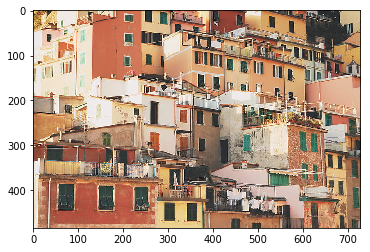

In [35]:
image_file_path = "Test/house.jpg"
im = np.array(PIL.Image.open(image_file_path).convert('RGB')).astype(np.float32)/255
plt.imshow(im)

#### Plot the activations for the image
SET `image_in_this_directory` to True if you want to test for images from a specific directory and then provide the path to the and `image_directory` variable


Provide value for the `image_file_name`

If `image_in_this_directory` is SET to False, the code will look for the test image in the `Test` directory under the current directory


The `num_top_maps` variable hold how many top activations need to be plotted as images below


The `show_maps_from_layers` variable tells the code to generate top feature maps from which layers

<span style="color:red">Warning: Code takes a lot of time and works only with a GPU</span>

Reading Image from /Users/navit/miniconda3/envs/env_notebooks/notebooks/Test/house.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


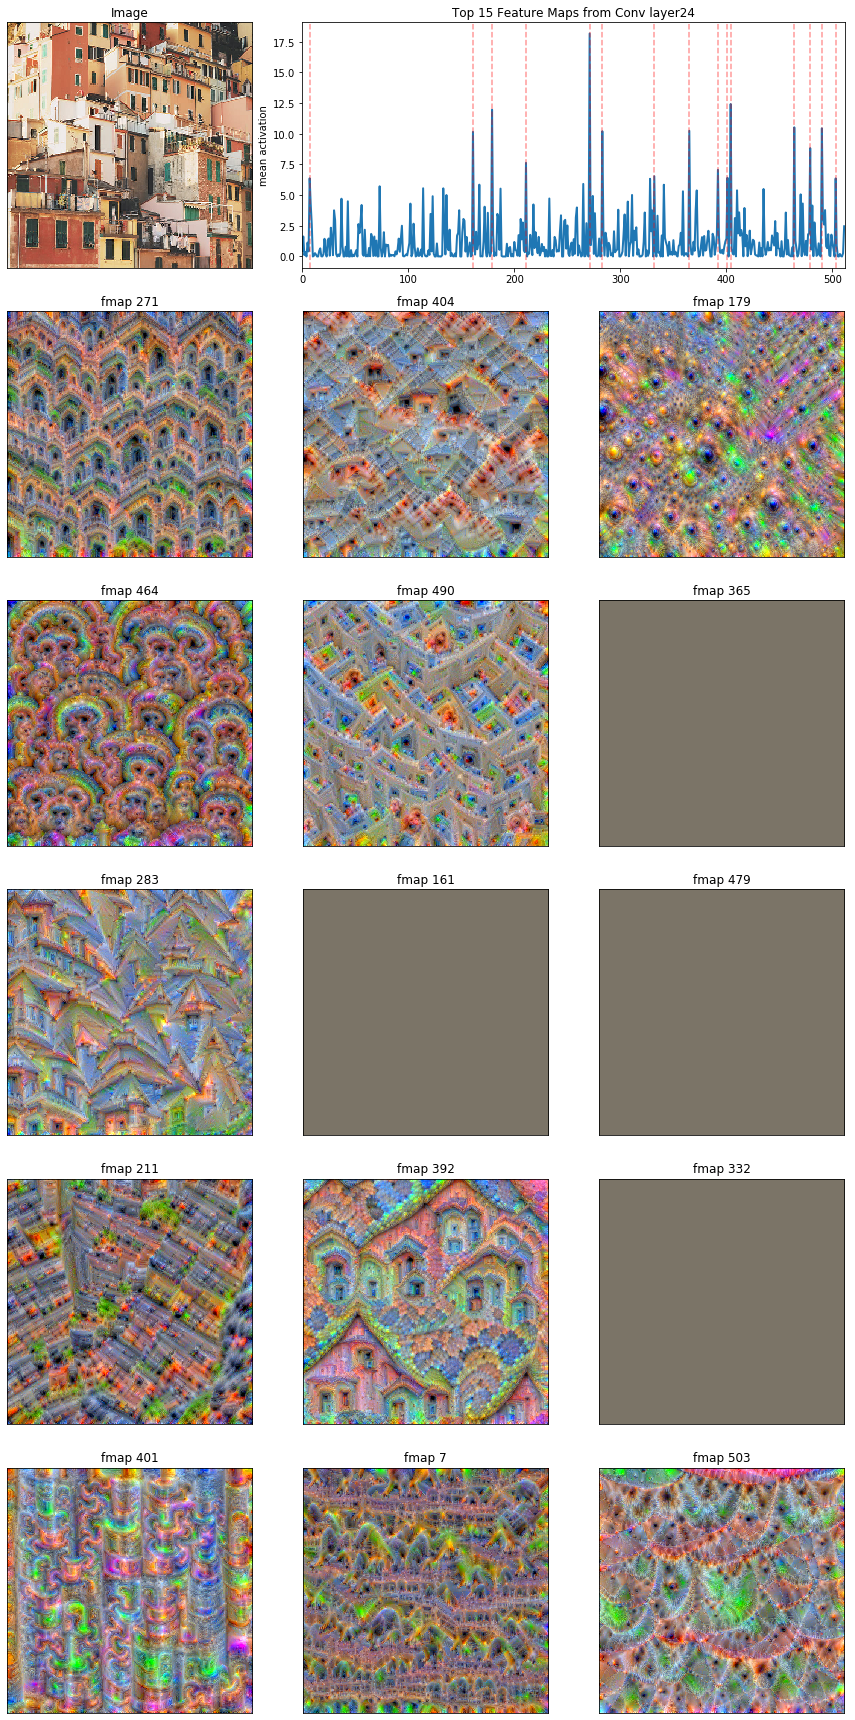

In [34]:
image_in_this_directory = False
image_directory = None
image_file_name = "house.jpg"
show_maps_from_layers = [24]

if not image_in_this_directory:
    if image_directory is None:
        image_directory = "./Test"
        if not (os.path.exists(os.path.abspath(image_directory)) and os.path.isdir(os.path.abspath(image_directory))):
            os.makedirs(os.path.abspath(image_directory))
elif image_directory is None:
    raise Exception("Please provide a valid image_directory")
    
img_path = os.path.abspath(os.path.join(image_directory, image_file_name))

print(f"Reading Image from {img_path}")    

num_top_maps = 15
im = np.array(PIL.Image.open(img_path).convert('RGB')).astype(np.float32)/255

for layer in show_maps_from_layers:
    activations_and_reconstructions(im,mods[0][layer],top_num=num_top_maps,upscaling_steps=12,layer_name=f'Top {num_top_maps} Feature Maps from Conv layer{layer}')